# Imports

In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

## Checking GPU

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Creating the Datasets

Define paramters for the data loaders

In [3]:
batch_size = 16
img_height = 48
img_width = 48
color_mode = 'rgb' # One of "grayscale", "rgb", "rgba".
validation_split = 0.2

dataset = "CK+"

train_data = "data/"+ dataset + "/train/"
test_data = "data/"+ dataset + "/test/"

print(train_data)
print(test_data)

data/CK+/train/
data/CK+/test/


Load the data into the datasets

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    color_mode = color_mode,
    validation_split=validation_split,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    color_mode = color_mode,
    validation_split=validation_split,
    label_mode="categorical",
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data,
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 720 files belonging to 7 classes.
Using 576 files for training.
Found 720 files belonging to 7 classes.
Using 144 files for validation.
Found 182 files belonging to 7 classes.


View the classes in the dataset

In [5]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Configuring the Datset
Enable buffered prefetching so you can yield data from disk without having I/O become blocking

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating the Model

In [7]:
from tensorflow.keras.layers import Input, Conv2D , MaxPool2D, Flatten, Dense 
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

num_classes = len(class_names)

# input
input = Input(shape=(img_height, img_width, 3) , name="img")

# Rescaling if the data is RGB
x = layers.experimental.preprocessing.Rescaling(1./255)(input)

# 1st Conv Block
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu', name="Conv1.1")(x)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu', name="Conv1.2")(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same', name="MaxPool2D_1")(x)

# 2nd Conv Block
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu', name="Conv2.1")(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu', name="Conv2.2")(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same', name="MaxPool2D_2")(x)

# 3rd Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu', name="Conv3.1")(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu', name="Conv3.2")(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu', name="Conv3.3")(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same', name="MaxPool2D_3" )(x)

# 4th Conv block
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name="Conv4.1")(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name="Conv4.2")(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name="Conv4.3")(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same', name="MaxPool2D_4")(x)

# 5th Conv block
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name="Conv5.1")(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name="Conv5.2")(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name="Conv5.3")(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same', name="MaxPool2D_5")(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(units = 4096, activation ='relu', name="Dense1")(x)
x = Dense(units = 4096, activation ='relu', name="Dense2")(x)

output = Dense(units = num_classes, activation ='softmax', name="DenseFinal")(x)

model = Model (inputs=input, outputs =output , name="VGG16")

## Compile the model

In [8]:
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## View Model Summary

In [9]:
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 48, 48, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 48, 48, 3)         0         
                                                                 
 Conv1.1 (Conv2D)            (None, 48, 48, 64)        1792      
                                                                 
 Conv1.2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 MaxPool2D_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 Conv2.1 (Conv2D)            (None, 24, 24, 128)       73856     
                                                                 
 Conv2.2 (Conv2D)            (None, 24, 24, 128)       147584

Plot the the CNN Model

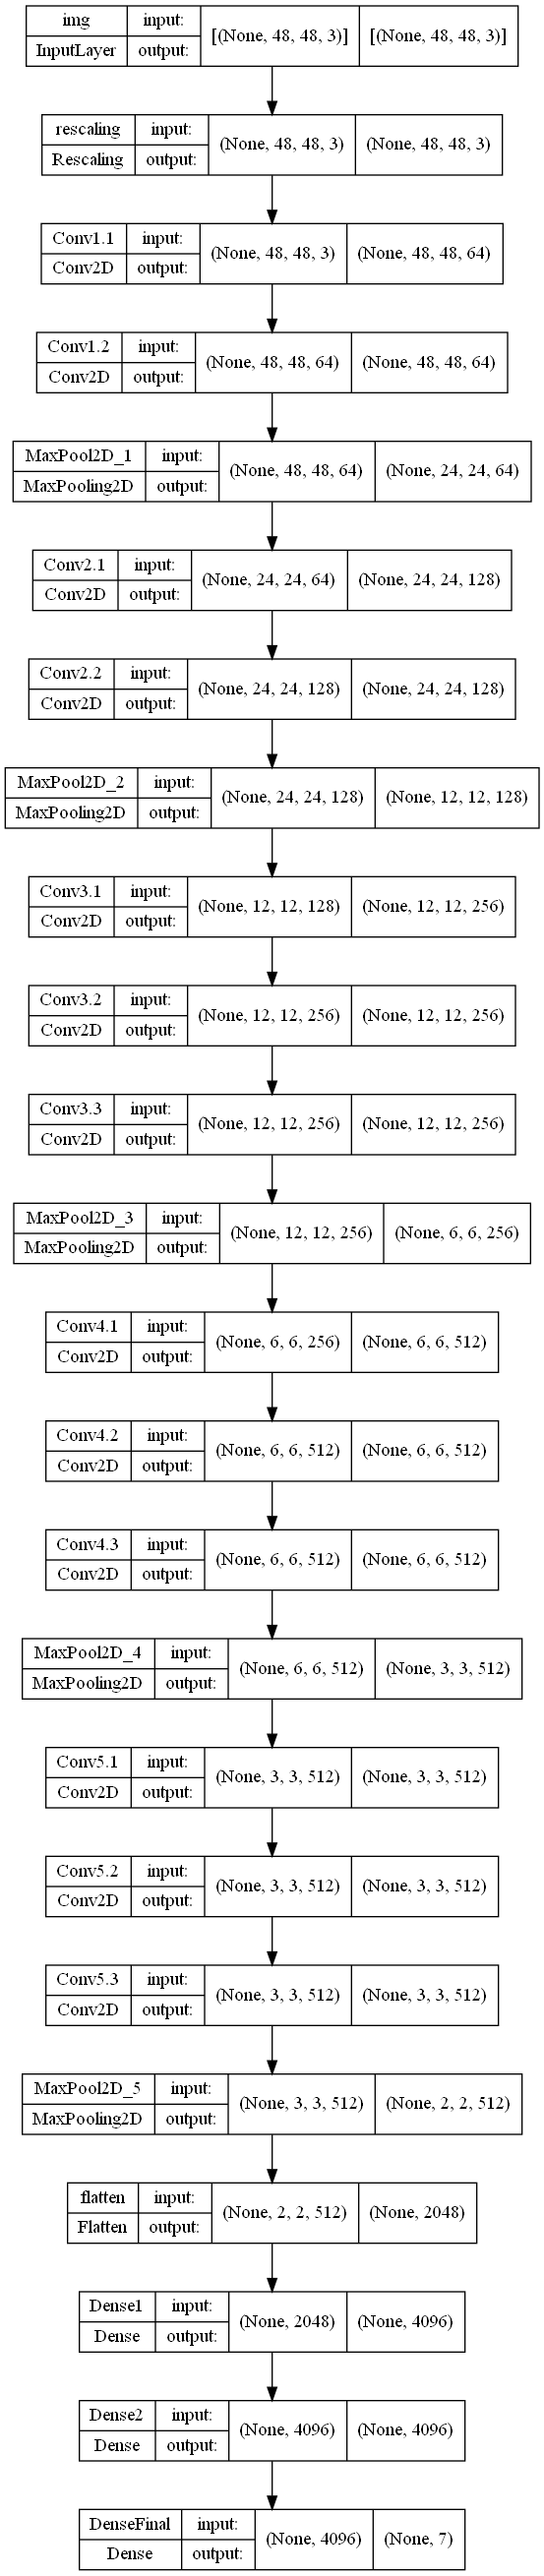

In [21]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image 


plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png', width = 400)

## Train the Model

In [20]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
27/27 [==============================] - 2s 54ms/step - loss: 1.4186 - accuracy: 0.6435 - val_loss: 1.2755 - val_accuracy: 0.6493
Epoch 2/50
27/27 [==============================] - 1s 45ms/step - loss: 1.2540 - accuracy: 0.6644 - val_loss: 1.5082 - val_accuracy: 0.6493
Epoch 3/50
27/27 [==============================] - 1s 45ms/step - loss: 1.3542 - accuracy: 0.6644 - val_loss: 1.3615 - val_accuracy: 0.6493
Epoch 4/50
27/27 [==============================] - 1s 45ms/step - loss: 1.2625 - accuracy: 0.6644 - val_loss: 1.3445 - val_accuracy: 0.6493
Epoch 5/50
27/27 [==============================] - 1s 45ms/step - loss: 1.2536 - accuracy: 0.6644 - val_loss: 1.2580 - val_accuracy: 0.6493
Epoch 6/50
27/27 [==============================] - 1s 45ms/step - loss: 1.2193 - accuracy: 0.6644 - val_loss: 1.2564 - val_accuracy: 0.6493
Epoch 7/50
27/27 [==============================] - 1s 46ms/step - loss: 1.2321 - accuracy: 0.6644 - val_loss: 1.2524 - val_accuracy: 0.6493
Epoch 8/50
27

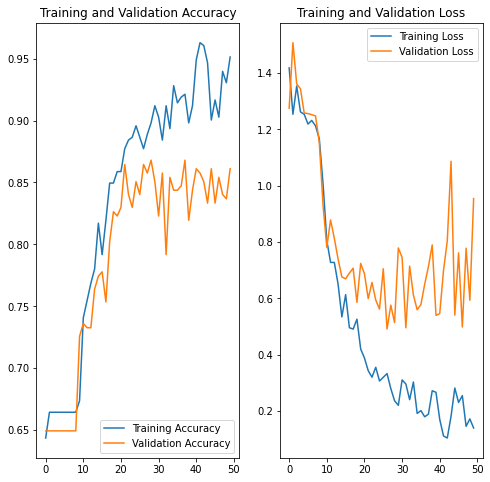

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluate the Model

In [22]:
print("Evaluate")
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

Evaluate
12/12 [==============================] - 0s 16ms/step - loss: 1.0133 - accuracy: 0.8462


{'loss': 1.0132657289505005, 'accuracy': 0.8461538553237915}